# Create dataset

In [1]:
from sklearn.datasets import make_circles

In [2]:
n_samples = 1000
x,y = make_circles(n_samples, noise = 0.03, random_state = 0)

# Visualize dataset

In [9]:
import pandas as pd

In [11]:
circles = pd.DataFrame({
    "x1": x[:, 0],
    "x2": x[:, 1],
    "label": y
})

In [12]:
circles.head(10)

,x1,x2,label
0,0.809935,-0.053514,1
1,-0.134486,-0.742095,1
2,-0.812506,-0.624244,0
3,0.583074,0.496568,1
4,-0.461320,0.659836,1
5,0.738485,-0.263874,1
6,0.925596,0.383517,0
7,-0.984430,0.230591,0
8,-0.818484,-0.686275,0
9,-0.694012,0.390175,1


In [14]:
circles.label.value_counts()

label
1    500
0    500
Name: count, dtype: int64

# Plot dataset

In [15]:
import matplotlib.pyplot as plt

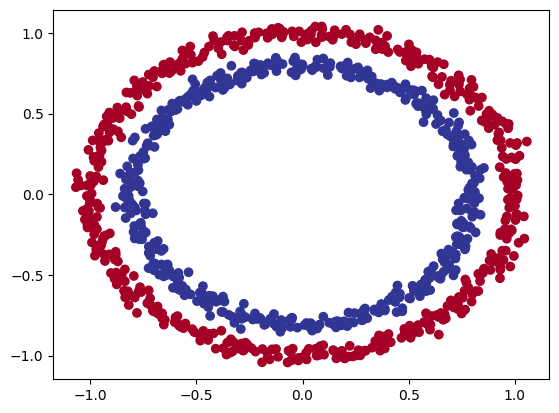

In [16]:
plt.scatter(
    x=x[:,0],
    y=x[:,1],
    c=y,
    cmap=plt.cm.RdYlBu
)

This is a toy dataset. <br>
It doesn't contain real data, but emulate it to propose a challenging problem useful to test machine learning algorithms

In [18]:
print(x[0], x.shape)
print(y[0], y.shape)

[ 0.80993549 -0.053514  ] (1000, 2)
1 (1000,)


# Prepare data to use in pytorch

In [19]:
import torch

In [20]:
x = torch.from_numpy(x).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [22]:
print(x[0], x.shape)
print(y[0], y.shape)

tensor([ 0.8099, -0.0535]) torch.Size([1000, 2])
tensor(1.) torch.Size([1000])


In [23]:
from sklearn.model_selection import train_test_split

In [24]:
xt, xv, yt, yv = train_test_split(
    x,
    y,
    test_size = 0.2,
    random_state=0
)
print(len(xt),len(yt),len(xv),len(yv))

800 800 200 200


# Set up device agnostic code

In [26]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


# Build model from nn.Module

In [43]:
from torch import nn

In [44]:
class PredictCircleModule(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(in_features = 2, out_features = 5)
        self.layer2 = nn.Linear(in_features = 5, out_features = 1)

    def forward(self, x):
        return self.layer2(self.layer1(x))

In [45]:
model = PredictCircleModule().to(device)
print(model)

PredictCircleModule(
  (layer1): Linear(in_features=2, out_features=5, bias=True)
  (layer2): Linear(in_features=5, out_features=1, bias=True)
)


In [46]:
yp = model(xt.to(device))
print(yp.shape, yt.shape)
print(yp[:5], yt[:5])

torch.Size([800, 1]) torch.Size([800])
tensor([[-0.0965],
        [ 0.0336],
        [ 0.0879],
        [ 0.0095],
        [-0.1944]], grad_fn=<SliceBackward0>) tensor([1., 1., 0., 0., 0.])


# Define loss function, optimizer, and evaluation metric

In [47]:
loss = nn.BCEWithLogitsLoss()
optim = torch.optim.SGD(
    params = model.parameters(),
    lr = 0.1
)

In [48]:
def accuracy(y, yp):
    correct = torch.eq(y, yp).sum().item()
    return (correct / len(yp)) * 100

## Observation about logits

In [55]:
logits = model(xt.to(device))
print(logits[:5])

tensor([[-0.0965],
        [ 0.0336],
        [ 0.0879],
        [ 0.0095],
        [-0.1944]], grad_fn=<SliceBackward0>)


In [56]:
yp = torch.sigmoid(logits)
print(yp[:5])

tensor([[0.4759],
        [0.5084],
        [0.5220],
        [0.5024],
        [0.4515]], grad_fn=<SliceBackward0>)


In [57]:
yp = torch.round(torch.sigmoid(logits))
print(yp[:5])

tensor([[0.],
        [1.],
        [1.],
        [1.],
        [0.]], grad_fn=<SliceBackward0>)


In [60]:
print(yp.squeeze()[:5])
print(yv.squeeze()[:5])

tensor([0., 1., 1., 1., 0.], grad_fn=<SliceBackward0>)
tensor([1., 1., 0., 0., 0.])


# Create training loop

## Step by step

### Forward pass
Pass an input, compute the forward function, store the results